In [1]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = False

In [4]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [6]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 52290 abstracts


In [7]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [ ]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [9]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [10]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,[unknown]
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,[unknown]
3387,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,"[unsupervised, reinforcement]"
3388,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,[unknown]
3389,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,[unknown]


In [11]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18101
supervised       11798
unsupervised      3754
reinforcement     1762
Name: count, dtype: int64

In [12]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,17,249,67,505
ml_automation,86,227,668,86
ml_defect_detection,13,287,272,102
ml_disassembly,15,102,150,24
ml_end_of_life,9,15,27,4
ml_inservice_monitoring,53,306,427,98
ml_manufacturing,345,2778,4514,792
ml_manufacturing_optimization,155,697,1192,139
ml_planning_production,173,681,833,139


In [13]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.356112
is_unsupervised     0.113311
is_reinforcement    0.053184
dtype: float64

<Axes: xlabel='ml_type'>

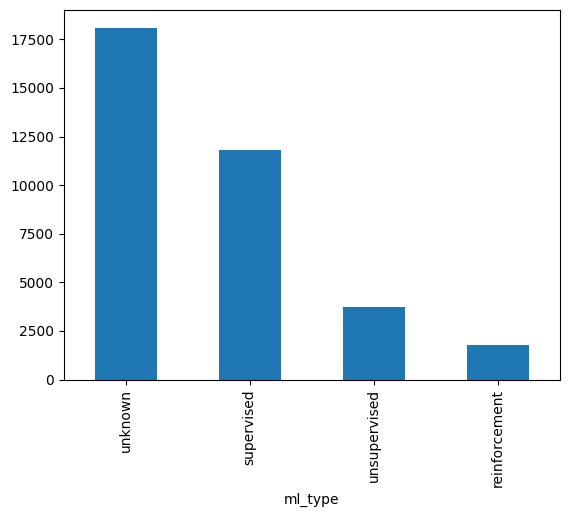

In [14]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

=== UNKNOWN abstracts (no keyword label) ===
count    18101.000000
mean      1410.373460
std        553.878203
min          0.000000
25%       1069.000000
50%       1341.000000
75%       1652.000000
max       8406.000000
Name: abs_length, dtype: float64

=== NOT UNKNOWN abstracts (>=1 keyword label) ===
count    15029.000000
mean      1514.883958
std        561.193086
min        291.000000
25%       1169.000000
50%       1441.000000
75%       1748.000000
max      12167.000000
Name: abs_length, dtype: float64


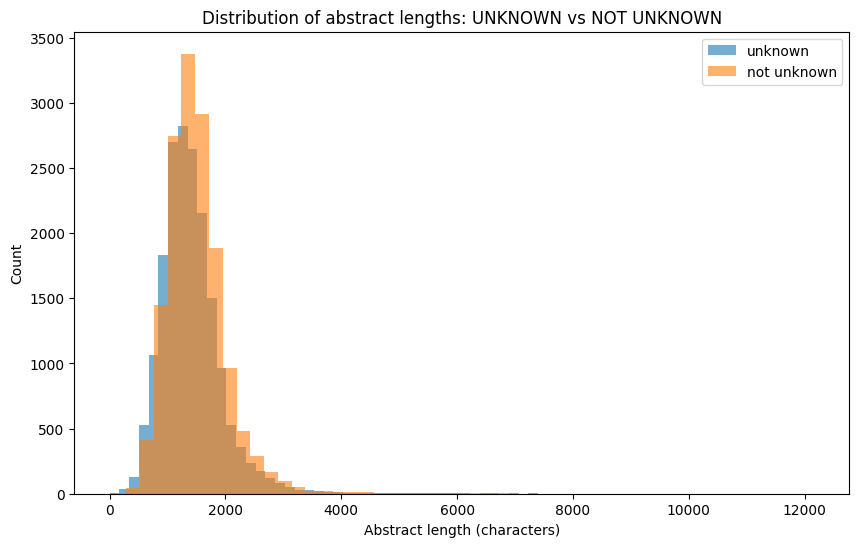

In [15]:
# Check average length of abstracts labeled 'unknown' vs the rest

# Ensure clean_abs is string
df["clean_abs"] = df["clean_abs"].fillna("").astype(str)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Determine unknown rows (no labels)
df["is_unknown"] = (df[label_cols].sum(axis=1) == 0).astype(int)

# Compute abstract length in characters
df["abs_length"] = df["clean_abs"].apply(len)

# Summary statistics
stats_unknown = df[df["is_unknown"] == 1]["abs_length"].describe()
stats_not_unknown = df[df["is_unknown"] == 0]["abs_length"].describe()

print("=== UNKNOWN abstracts (no keyword label) ===")
print(stats_unknown)
print("\n=== NOT UNKNOWN abstracts (>=1 keyword label) ===")
print(stats_not_unknown)

# Optional: quick comparison plot
plt.figure(figsize=(10,6))
plt.hist(df[df["is_unknown"] == 1]["abs_length"], bins=50, alpha=0.6, label="unknown")
plt.hist(df[df["is_unknown"] == 0]["abs_length"], bins=50, alpha=0.6, label="not unknown")
plt.xlabel("Abstract length (characters)")
plt.ylabel("Count")
plt.title("Distribution of abstract lengths: UNKNOWN vs NOT UNKNOWN")
plt.legend()
plt.show()


In [16]:
# Check share of abstracts labeled unknown under different word count thresholds

dfq = df.copy()
dfq["clean_abs"] = dfq["clean_abs"].fillna("").astype(str)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Define unknown rows
dfq["is_unknown"] = (dfq[label_cols].sum(axis=1) == 0).astype(int)

# Word count
dfq["word_count"] = dfq["clean_abs"].apply(lambda x: len(x.split()))

# Thresholds to evaluate
thresholds = [50, 75, 100, 125, 150, 200, 250, 300, 350, 400]

results = []

total = len(dfq)

for t in thresholds:
    mask = dfq["word_count"] < t

    total_under = mask.sum()
    unknown_under = (mask & (dfq["is_unknown"] == 1)).sum()

    results.append({
        "threshold_words": t,
        "total_under": total_under,
        "pct_of_total": total_under / total,
        "unknown_under": unknown_under,
        "pct_unknown_of_under": unknown_under / total_under if total_under > 0 else 0
    })

df_thresh = pd.DataFrame(results)

print(df_thresh)


   threshold_words  total_under  pct_of_total  unknown_under  \
0               50           61      0.001841             55   
1               75          248      0.007486            207   
2              100         1161      0.035044            878   
3              125         3101      0.093601           2162   
4              150         6940      0.209478           4487   
5              200        17675      0.533504          10478   
6              250        26407      0.797072          14894   
7              300        30294      0.914398          16731   
8              350        31762      0.958708          17445   
9              400        32428      0.978811          17756   

   pct_unknown_of_under  
0              0.901639  
1              0.834677  
2              0.756245  
3              0.697194  
4              0.646542  
5              0.592815  
6              0.564017  
7              0.552288  
8              0.549241  
9              0.547551  


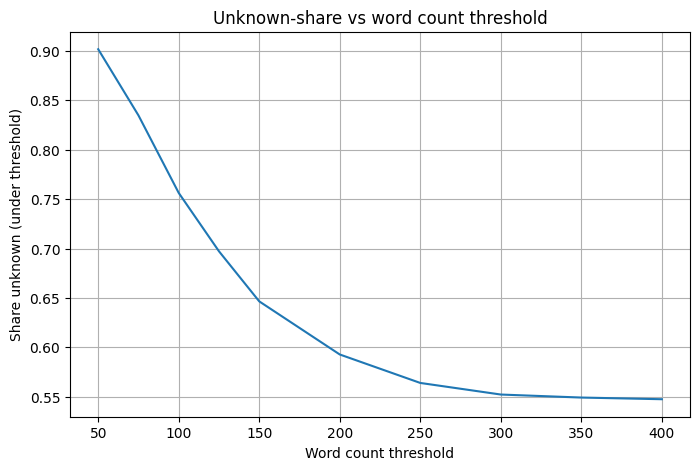

In [17]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(df_thresh["threshold_words"], df_thresh["pct_unknown_of_under"])
plt.xlabel("Word count threshold")
plt.ylabel("Share unknown (under threshold)")
plt.title("Unknown-share vs word count threshold")
plt.grid(True)
plt.show()


In [22]:
# Create save directory
save_path = processed_abstracts_path / "keywords"
save_path.mkdir(parents=True, exist_ok=True)

# Columns to save
save_columns = [
    "query_id",
    "doi",
    "clean_abs",
    "is_supervised",
    "is_unsupervised",
    "is_reinforcement"
]

# Check that all expected columns exist
missing_cols = [c for c in save_columns if c not in df.columns]
if missing_cols:
    raise ValueError(f"The following required columns are missing from df: {missing_cols}")

# Save only selected columns
output_file = save_path / "abstracts_with_labels.csv"
df[save_columns].to_csv(output_file, index=False, encoding="utf-8")

print(f"Saved labeled abstracts to:\n{output_file}")
print(f"Total rows saved: {len(df)}")


Saved labeled abstracts to:
../../data/processed/abstracts/keywords/abstracts_with_labels.csv
Total rows saved: 33130
